In [9]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import drive


In [5]:
# Google Drive'ı bağla
drive.mount('/content/drive')

# Datasetin bulunduğu yolu belirleyelim
dataset_path = "/content/drive/MyDrive/dataset"

# Train, Validation ve Test dizinlerini oluştur
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

# Parametreler
img_size = (224, 224)  # Görsellerin boyutu
batch_size = 512  # Batch boyutu
num_classes = 3  # Sınıf sayısı

# Veri setlerini yükle
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Sınıf adlarını al
class_names = train_ds.class_names
print(f"Sınıf isimleri: {class_names}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 6739 files belonging to 3 classes.
Found 1685 files belonging to 3 classes.
Found 2106 files belonging to 3 classes.
Sınıf isimleri: ['glass', 'paper', 'plastic']


In [6]:
# Performans için önbelleğe alma ve prefetch işlemleri
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# ResNet50 modelini oluştur
def create_resnet50_model(input_shape, num_classes):
    # Önceden eğitilmiş ResNet50 modelini yükle (weights='imagenet')
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Base modeli dondur (fine-tuning aşamasında açabiliriz)
    base_model.trainable = False

    # Model mimarisini oluştur
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [8]:
# Modeli oluştur ve derle
model = create_resnet50_model(img_size + (3,), num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model özeti
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,121,219 (92.02 MB)

 Trainable params: 529,411 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [11]:
# ReduceLROnPlateau callback'i tanımla
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# EarlyStopping callback'i tanımla
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6970 - loss: 0.8659 - val_accuracy: 0.8938 - val_loss: 0.3003 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9398 - loss: 0.1838 - val_accuracy: 0.9187 - val_loss: 0.2266 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9638 - loss: 0.1019 - val_accuracy: 0.9436 - val_loss: 0.1624 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.9778 - loss: 0.0589 - val_accuracy: 0.9519 - val_loss: 0.1408 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9851 - loss: 0.0422 - val_accuracy: 0.9608 - val_loss: 0.1230 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9880 - loss: 0.0373 - val_accuracy: 0.9632 - val_loss: 0.1181 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9893 - loss: 0.02

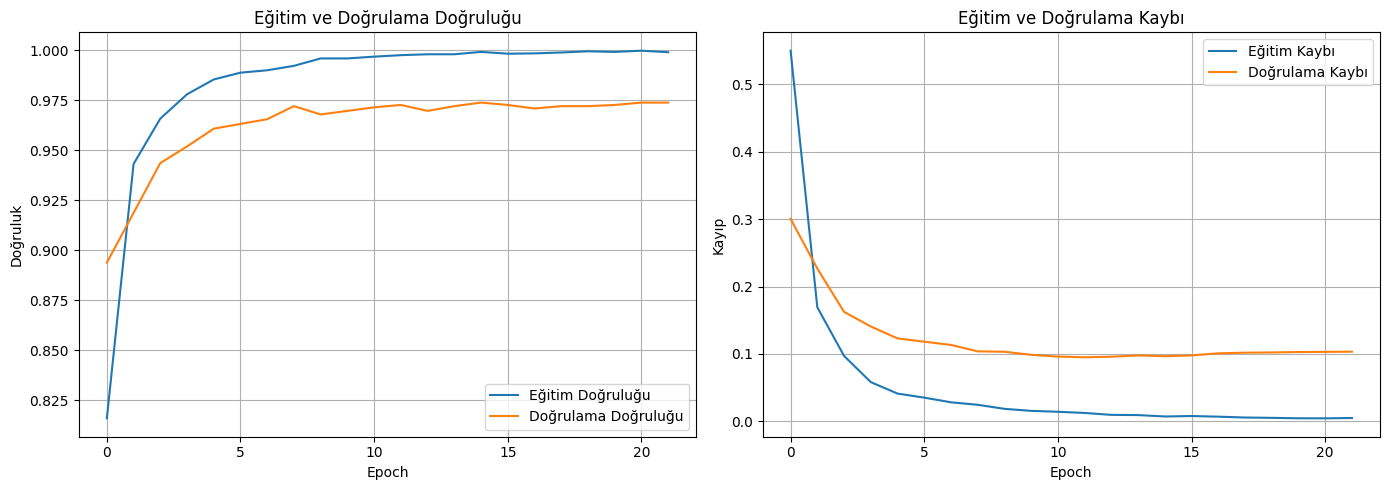

In [13]:
# Eğitim sonuçlarını görselleştir
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Eğitimin gerçekleşen epoch sayısını al
    epochs_completed = len(acc)

    plt.figure(figsize=(14, 5))

    # Doğruluk (Accuracy) grafiği
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs_completed), acc, label='Eğitim Doğruluğu')
    plt.plot(range(epochs_completed), val_acc, label='Doğrulama Doğruluğu')
    plt.title('Eğitim ve Doğrulama Doğruluğu')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid(True)

    # Kayıp (Loss) grafiği
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs_completed), loss, label='Eğitim Kaybı')
    plt.plot(range(epochs_completed), val_loss, label='Doğrulama Kaybı')
    plt.title('Eğitim ve Doğrulama Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Eğitim ve doğrulama grafiklerini çiz
plot_training_history(history)

In [14]:
# Test veri seti üzerinde değerlendirme
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Doğruluğu: {test_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 70s 13s/step - accuracy: 0.9777 - loss: 0.0663

Test Doğruluğu: 0.9758


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


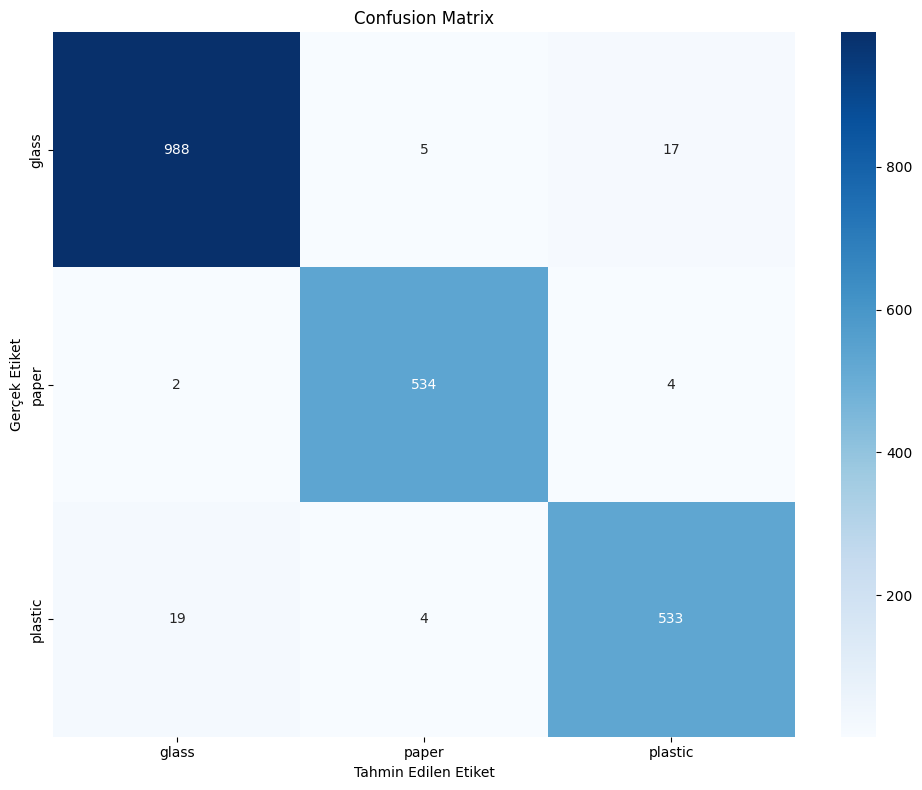

In [15]:
# Karışıklık matrisi ve sınıflandırma raporu için tahminleri al
y_pred_prob = []
y_true = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    batch_pred = model.predict(images)
    y_pred_prob.extend(batch_pred)

y_pred = np.argmax(np.array(y_pred_prob), axis=1)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Gerçek Etiket')
    plt.xlabel('Tahmin Edilen Etiket')
    plt.tight_layout()
    plt.show()

# Karışıklık matrisini çiz
plot_confusion_matrix(y_true, y_pred, class_names)

In [16]:
# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=class_names))



Sınıflandırma Raporu:
              precision    recall  f1-score   support

       glass       0.98      0.98      0.98      1010
       paper       0.98      0.99      0.99       540
     plastic       0.96      0.96      0.96       556

    accuracy                           0.98      2106
   macro avg       0.97      0.98      0.98      2106
weighted avg       0.98      0.98      0.98      2106

